In [136]:
import pandas as pd
from pandas import read_excel
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pyplot
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from string import ascii_letters
import seaborn as sns
from datetime import datetime

import statsmodels.api as sm
from statsmodels.tsa.api import VAR

In [161]:
data = read_excel("monthly_data.xlsx")
dfa = pd.read_excel (r'monthly_data.xlsx')

data['year']=pd.to_datetime(data['year'], format = '%Y-%m')
data.set_index('year', inplace=True)

train_size = int(len(ts1) * 0.8)
df_train, df_test = data[0:train_size], data[train_size:]

print(len(df_train))
print(len(df_test))

48
12


In [138]:
#check datatype of index
#print(data.index)
print(data.head())
print(data.dtypes)

            max_temp  min_temp  rainfall(mm)  humidity  dengue  Leptospirosis
year                                                                         
2014-01-01      32.8      22.2         0.000     67.75       1              0
2014-02-01      32.8      22.8         7.650     71.25       0              0
2014-03-01      34.1      24.2        27.670     72.37       0              0
2014-04-01      34.3      25.7       100.375     77.25       5              0
2014-05-01      33.9      25.3       290.120     79.12      28              0
max_temp         float64
min_temp         float64
rainfall(mm)     float64
humidity         float64
dengue             int64
Leptospirosis      int64
dtype: object


In [71]:
ts1 = data['dengue']
ts2 = data['Leptospirosis']

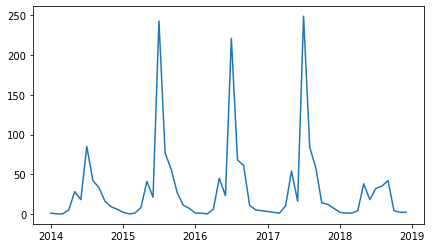

In [72]:
plt.figure(figsize=(7,4))
plt.plot(ts1, label='dengue cases')

In [73]:
train_size = int(len(ts1) * 0.8)
train, test = ts1[0:train_size], ts1[train_size:]

In [74]:
print(len(train))
print(len(test))

48
12


In [75]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

## Model -1 (Non-stationary) - dengue

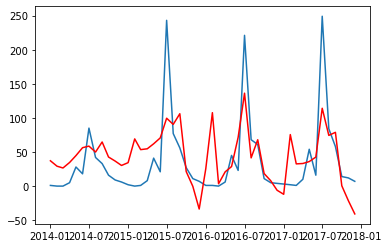

In [76]:
model = ARIMA(train, order=(4, 0, 6))
model_fit = model.fit(disp=False)
plt.plot(train)
plt.plot(model_fit.fittedvalues, color='red')

In [77]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(1,0,3))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

predicted=15.595259, expected=2.000000
predicted=13.779099, expected=1.000000
predicted=22.190116, expected=1.000000
predicted=28.785339, expected=4.000000
predicted=31.776274, expected=38.000000
predicted=38.986093, expected=18.000000
predicted=45.726731, expected=32.000000
predicted=37.174859, expected=35.000000
predicted=42.842457, expected=42.000000
predicted=45.093767, expected=4.000000
predicted=39.585906, expected=2.000000
predicted=31.485313, expected=2.000000
Test MSE: 504.605


In [78]:
from pandas import DataFrame
type(predictions)

list

In [79]:
#newDF = pd.DataFrame()
df=pd.DataFrame(test.index)
df['value']=predictions
df['pvalue']=pd.DataFrame(predictions)
newdf=df.drop(['value'], axis=1)

In [80]:
newdf

,year,pvalue
0,2018-01-01,15.595259
1,2018-02-01,13.779099
2,2018-03-01,22.190116
3,2018-04-01,28.785339
4,2018-05-01,31.776274
5,2018-06-01,38.986093
6,2018-07-01,45.726731
7,2018-08-01,37.174859
8,2018-09-01,42.842457
9,2018-10-01,45.093767


In [81]:
newdf['year']=pd.to_datetime(newdf['year'], format = '%Y-%m')
newdf.set_index('year', inplace=True)

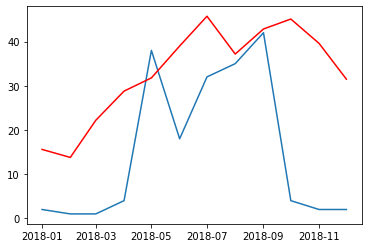

In [82]:
plt.plot(test)
plt.plot(newdf, color='red')
plt.show()

## Model -2 (stationary) - dengue

In [83]:
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
import numpy
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load dataset
series = ts1
# seasonal difference
X = series.values
days_in_year = 12
differenced = difference(X, days_in_year)
# fit model
model = ARIMA(differenced, order=(2,0,4))
model_fit = model.fit(disp=0)
# multi-step out-of-sample forecast
forecast = model_fit.forecast(steps=12)[0]
# invert the differenced forecast to something usable
history = [x for x in X]
day = 1
big_array = []
for yhat in forecast:
    inverted = inverse_difference(history, yhat, days_in_year)
    #print('Day %d: %f' % (day, inverted))
    big_array.append(inverted)
    history.append(inverted)
    day += 1

In [84]:
print(type(big_array))
big_np_array = np.array(big_array)
print(type(big_np_array))
print(big_np_array)

<class 'list'>
<class 'numpy.ndarray'>
[-0.79235401 -1.03515824 -0.76830705  2.49432498 36.57020887 16.63341432
 30.6494746  33.66480319 40.66809812  2.67184762  0.67249136  0.67341717]


In [85]:
big_np_array[big_np_array<0] = 0
print(big_np_array)

[ 0.          0.          0.          2.49432498 36.57020887 16.63341432
 30.6494746  33.66480319 40.66809812  2.67184762  0.67249136  0.67341717]


In [87]:
new_arr = np.ceil(big_np_array)
print(new_arr)

[ 0.  0.  0.  3. 37. 17. 31. 34. 41.  3.  1.  1.]


## Model -3 (stationary) - Leptospirosis

In [96]:
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
import numpy
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load dataset
series = ts2
# seasonal difference
X = series.values
days_in_year = 12
differenced = difference(X, days_in_year)
# fit model
model = ARIMA(differenced, order=(2,0,4))
model_fit = model.fit(disp=0)
# multi-step out-of-sample forecast
forecast = model_fit.forecast(steps=12)[0]
# invert the differenced forecast to something usable
history = [x for x in X]
day = 1
big_array1 = []
for yhat in forecast:
    inverted = inverse_difference(history, yhat, days_in_year)
    #print('Day %d: %f' % (day, inverted))
    big_array1.append(inverted)
    history.append(inverted)
    day += 1

In [97]:
print(type(big_array1))
big_np_array1 = np.array(big_array1)
print(type(big_np_array1))
print(big_np_array1)

<class 'list'>
<class 'numpy.ndarray'>
[-0.5075597   1.68808348  0.51041855 -2.79934013 -3.16014715  5.85175068
 12.96571125 14.42714921 28.72854857  5.67255487  3.76650606  0.48203089]


In [98]:
big_np_array1[big_np_array1<0] = 0
print(big_np_array1)

[ 0.          1.68808348  0.51041855  0.          0.          5.85175068
 12.96571125 14.42714921 28.72854857  5.67255487  3.76650606  0.48203089]


In [99]:
new_arr1 = np.ceil(big_np_array1)
print(new_arr1)

[ 0.  2.  1.  0.  0.  6. 13. 15. 29.  6.  4.  1.]


In [101]:
d = pd.date_range(start='1/1/2019', end='12/1/2019', freq='MS')    
print(d)

DatetimeIndex(['2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', freq='MS')


In [103]:
forecast_2019 = pd.DataFrame()

In [106]:
forecast_2019['year']=d
forecast_2019['Leptospirosis']=new_arr1
forecast_2019['dengue']=new_arr

In [107]:
forecast_2019

,year,Leptospirosis,dengue
0,2019-01-01,0.0,0.0
1,2019-02-01,2.0,0.0
2,2019-03-01,1.0,0.0
3,2019-04-01,0.0,3.0
4,2019-05-01,0.0,37.0
5,2019-06-01,6.0,17.0
6,2019-07-01,13.0,31.0
7,2019-08-01,15.0,34.0
8,2019-09-01,29.0,41.0
9,2019-10-01,6.0,3.0
